In [355]:
# %load /home/jonathan/.ipython/profile_default/startup/01-setup.py
# start up settings for jupyter notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys

# use plt.style.available() to check out available styles
plt.style.use('seaborn-white')
plt.rcParams['font.size'] = 20.0
plt.rcParams['axes.labelsize'] = 20.0
plt.rcParams['xtick.labelsize'] = 20.0
plt.rcParams['ytick.labelsize'] = 20.0
plt.rcParams['legend.fontsize'] = 20.0

%matplotlib inline

# set the max column width
pd.options.display.max_colwidth = 1000

# to avoid have warnings from chained assignments
pd.options.mode.chained_assignment = None


In [356]:
import json
import itertools as itls
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.ticker import MultipleLocator

In [357]:
TRACE_STATS_ENRICHED_FILENAME = 'trace-stats-enriched.csv'
TRACE_STATS_FILENAME = 'trace-stats.csv'
CONFIGS_JSON_FILENAME = 'configs.json'
REPLAY_ID = 'replay_id'
ALIGNMENT_FILENAME = 'alignments.json'
ALIGNMENT_FPATH = 'alignment_fpath'

# things to ignore from configs
OUTFILE_KEY = 'outFile'
RESULTDIR_KEY = 'resultDir'
LOGPATH_KEY = 'logPath'
MODELPATH_KEY = 'modelPath'
TO_IGNORE_KEY_LIST = [
    OUTFILE_KEY, 
    RESULTDIR_KEY,
    LOGPATH_KEY,
    MODELPATH_KEY
]


def mono_read_trace_stats(replay_id, replay_dirpath):
    trace_stats_fpath = os.path.join(replay_dirpath, TRACE_STATS_ENRICHED_FILENAME)
    configs_fpath = os.path.join(replay_dirpath, CONFIGS_JSON_FILENAME)
    alignment_fpath = os.path.join(replay_dirpath, ALIGNMENT_FILENAME)
    
    with open(configs_fpath, 'r') as f:
        configs_dict = json.load(f)
        
    for key in TO_IGNORE_KEY_LIST:
        del configs_dict[key]
        
    trace_stats_df = pd.read_csv(trace_stats_fpath)
    trace_stats_df[REPLAY_ID] = replay_id
    trace_stats_df[ALIGNMENT_FPATH] = alignment_fpath
    
    for key, item in configs_dict.items():
        trace_stats_df[key] = item
        
    return trace_stats_df


def reco_read_trace_stats(replay_id, replay_dirpath):
    trace_stats_fpath = os.path.join(replay_dirpath, TRACE_STATS_FILENAME)
    configs_fpath = os.path.join(replay_dirpath, CONFIGS_JSON_FILENAME)
    alignment_fpath = os.path.join(replay_dirpath, ALIGNMENT_FILENAME)
    
    with open(configs_fpath, 'r') as f:
        configs_dict = json.load(f)
        
    for key in TO_IGNORE_KEY_LIST:
        del configs_dict[key]
        
    trace_stats_df = pd.read_csv(trace_stats_fpath)
    trace_stats_df[REPLAY_ID] = replay_id
    trace_stats_df[ALIGNMENT_FPATH] = alignment_fpath
    
    for key, item in configs_dict.items():
        trace_stats_df[key] = item
        
    return trace_stats_df

In [358]:
mono_inc3_basedir = '../../results-agg/clst_2018_12/2018-12-11_06-46-11-339718_BPI2018-net1-nILP-inc3-mono'
reco_sese_inc3_basedir = '../../results-agg/clst_2018_12/2018-12-25_07-10-36-499180_BPI2018-net1-nILP-inc3-sese_25-score-strict'
reco_gene_inc3_basedir = '../../results-agg/clst_2018_12/2018-12-26_02-24-47-110351_BPI2018-net1-nILP-inc3-generic_50-score-strict'

mono_inc3_stats_df_list = []
reco_sese_inc3_stats_df_list = []
reco_gene_inc3_stats_df_list = []

for d in os.listdir(mono_inc3_basedir):
    replay_dirpath = os.path.join(mono_inc3_basedir, d)
    if not os.path.isdir(replay_dirpath):
        continue
        
    trace_stats_df = mono_read_trace_stats(d, replay_dirpath)
    mono_inc3_stats_df_list.append(trace_stats_df)
    
for d in os.listdir(reco_sese_inc3_basedir):
    replay_dirpath = os.path.join(reco_sese_inc3_basedir, d)
    if not os.path.isdir(replay_dirpath):
        continue
        
    trace_stats_df = reco_read_trace_stats(d, replay_dirpath)
    reco_sese_inc3_stats_df_list.append(trace_stats_df)

for d in os.listdir(reco_gene_inc3_basedir):
    replay_dirpath = os.path.join(reco_gene_inc3_basedir, d)
    if not os.path.isdir(replay_dirpath):
        continue
        
    trace_stats_df = reco_read_trace_stats(d, replay_dirpath)
    reco_gene_inc3_stats_df_list.append(trace_stats_df)    
    
mono_inc3_stats_df = pd.concat(mono_inc3_stats_df_list, axis=0)
reco_sese_inc3_stats_df = pd.concat(reco_sese_inc3_stats_df_list, axis=0)
reco_gene_inc3_stats_df = pd.concat(reco_gene_inc3_stats_df_list, axis=0)

# merge the recomposing results with the monolithic results
merge_on = [REPLAY_ID, 'SP label']
suffixes = ('_mono', '_reco')

sese_inc3_stats_df = mono_inc3_stats_df.merge(reco_sese_inc3_stats_df, on=merge_on, suffixes=suffixes)
gene_inc3_stats_df = mono_inc3_stats_df.merge(reco_gene_inc3_stats_df, on=merge_on, suffixes=suffixes)

### Plot net1-10-10

In [746]:
def plot_time_analysis_2(df, plot_params, fig=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    hist_color = plot_params['hist_color']
    hist_alpha = plot_params['hist_alpha']
    hist_n_bins = plot_params['hist_n_bins']
    hist_edgecolor = plot_params['hist_edgecolor']
    hist_linewidth = plot_params['hist_linewidth']
    cum_marker = plot_params['cum_marker']
    cum_color = plot_params['cum_color']
    cum_linestyle = plot_params['cum_linestyle']
    
    # get the bins
    alignment_times_df = df.loc[:,['Total Time including setup (us)']].copy()
    alignment_times = df['Total Time including setup (us)'].infer_objects()
    alignment_times_df['bin'] = pd.cut(alignment_times, hist_n_bins)
    bins = [interval.left for interval in alignment_times_df['bin'].dtype.categories] + [alignment_times_df['bin'].dtype.categories[-1].right + 1]
    
    # compute cumulative data
    total_time = alignment_times.sum()
    n_traces = alignment_times_df.shape[0]
    cum_df = alignment_times_df.groupby('bin').agg({'Total Time including setup (us)': ['sum', 'count']})
    cum_df.loc[:,('Total Time including setup (us)', 'sum')] = cum_df.loc[:,('Total Time including setup (us)', 'sum')].cumsum() / total_time * 100.
    get_mid = lambda interval: (interval.left + interval.right) / 2.
    bin_mid_list = [get_mid(interval) for interval in alignment_times_df['bin'].dtype.categories]
    
    ax_twin = ax.twinx()
    
    # histogram of times
    ax.hist(alignment_times, bins=bins, color=hist_color, alpha=hist_alpha, 
            linewidth=hist_linewidth, edgecolor=hist_edgecolor)
    cum_perc = cum_df.loc[:, ('Total Time including setup (us)', 'sum')]
    ax_twin.plot(bin_mid_list, cum_perc, marker=cum_marker, linestyle=cum_linestyle, color=cum_color)
    
    # ylim
    ax_twin.set_ylim([0., 110.])
    ax.set_ylim([-20, n_traces + 40])
    
    # grid lines
    ax_twin.grid()
    
    # ticks
    yticks = range(0, 110, 10)
    ax_twin.set_yticks(yticks)
    
    # labels
    ax.set_xlabel('Total time including setup (s)')
    ax.set_ylabel('Count')
    ax_twin.set_ylabel('Cum. perc. of total time (%)')
    
    # histogram labels
    for i in range(hist_n_bins):
        bin_count = cum_df.loc[:, ('Total Time including setup (us)', 'count')].values[i]
        bin_mid = bin_mid_list[i]
        text_params = {
            'fontsize': 20,
            'verticalalignment': 'bottom',
            'horizontalalignment': 'center'
        }
        ax.text(bin_mid, bin_count, '{}'.format(bin_count), text_params)
        
    fig.tight_layout()
        
    return fig, ax

def plot_time_analysis(df, plot_params, fig=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
        
    time_color = plot_params['time_color']
    time_marker = plot_params['time_marker']
    time_markersize = plot_params['time_markersize']
    perc_color = plot_params['perc_color']
    perc_linestyle = plot_params['perc_linestyle']
    perc_linewidth = plot_params['perc_linewidth']
    
    n_traces = df.shape[0]
    trace_lengths = df['merged_alignment_log_trace_length'] if 'merged_alignment_log_trace_length' in df else df['Length of the orignal trace']
    alignment_times = df['Total Time including setup (us)']
    ax.plot(df.index.values, alignment_times, time_marker, color=time_color, markersize=time_markersize)
    ax_twin = ax.twinx()
    ax_twin.plot(df.index.values, df['cum_perc_of_log_time'], color=perc_color, linestyle=perc_linestyle, linewidth=perc_linewidth)
    
    # labels
    ax.set_xlabel('Trace')
    ax.set_ylabel('Total time including setup (s)', fontsize=15)
    ax_twin.set_ylabel('Cumulative percentage of total time (%)', fontsize=15)
    
#     ax_twin.axvline(n_traces * 0.95, 0, 100)
    
    # ticks
    xticks = range(0, n_traces, 10)
    yticks = range(0, 110, 10)
    ax_twin.set_yticks(yticks)
#     ax.set_xticks(xticks)
    
    # grid 
    ax_twin.grid();
#     ml = MultipleLocator(20.)
#     ax.xaxis.set_minor_locator(ml)
#     ax.xaxis.grid(which="minor", color='k', linestyle='-.', linewidth=0.7)
    
    return fig, ax

def plot_algo_analysis(df, plot_params, fig=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    color = plot_params['color']
    marker = plot_params['marker']
    markersize = plot_params['markersize']
    
    alignment_costs = df['merged_alignment_cost'] if 'merged_alignment_cost' in df else df['Cost of the alignment']
    trace_lengths = df['merged_alignment_log_trace_length'] if 'merged_alignment_log_trace_length' in df else df['Length of the orignal trace']
    alignment_times = df['Total Time including setup (us)']
    ax.plot(trace_lengths, alignment_times, marker, color=color, markersize=markersize)
    
    # labels
    ax.set_xlabel('Log trace length')
    ax.set_ylabel('Total time including setup (s)', fontsize=15)
    
    # grid
    ml = MultipleLocator(10.)
    ax.yaxis.set_minor_locator(ml)
    ax.yaxis.grid(which='major', color='k', linestyle='-', linewidth=0.7)
    ax.xaxis.set_minor_locator(ml)
    ax.xaxis.grid(which='minor', color='k', linestyle='-.', linewidth=0.7)
    
    return fig, ax

In [747]:
def compute_time_stats(df):
    df.sort_values('Total Time including setup (us)', inplace=True)
    df.reset_index(drop=True, inplace=True)
    # convert microseconds to seconds
    df['Total Time including setup (us)'] /= 1000000
    
    total_computation_time = df['Total Time including setup (us)'].sum()
    print('Total computation time: {}s'.format(total_computation_time))
    df['perc_of_log_time'] = df['Total Time including setup (us)'] / total_computation_time * 100.
    df['cum_perc_of_log_time'] = df['perc_of_log_time'].cumsum()
    
    return df

mono_nonempty_traces = mono_inc3_stats_df['SP label'] != 'Empty'
reco_nonempty_traces = reco_sese_inc3_stats_df['SP label'] != 'Empty'
mono_unfitting_traces = mono_inc3_stats_df['Cost of the alignment'] > 0
reco_unfitting_traces = reco_sese_inc3_stats_df['merged_alignment_cost'] > 0
mono_valid_alignments = mono_inc3_stats_df['Exit code for alignment'] == 1
reco_valid_alignments = reco_sese_inc3_stats_df['Exit code for alignment'] == 1

mono_stats_df_net1_10_10 = mono_inc3_stats_df[
    (mono_inc3_stats_df['log'] == 'net1-10-10-l1000') & 
    (mono_unfitting_traces) & 
    (mono_valid_alignments) &
    (mono_nonempty_traces)
]
compute_time_stats(mono_stats_df_net1_10_10)

reco_sese_stats_df_net1_10_10 = reco_sese_inc3_stats_df[
    (reco_sese_inc3_stats_df['log'] == 'net1-10-10-l1000') & 
    (reco_unfitting_traces) &
    (reco_valid_alignments) &
    (reco_nonempty_traces)
]
compute_time_stats(reco_sese_stats_df_net1_10_10)

mono_stats_df_net1_10_60 = mono_inc3_stats_df[
    (mono_inc3_stats_df['log'] == 'net1-10-60-l1000') & 
    (mono_unfitting_traces) & 
    (mono_valid_alignments) &
    (mono_nonempty_traces)
]
compute_time_stats(mono_stats_df_net1_10_60)

reco_sese_stats_df_net1_10_60 = reco_sese_inc3_stats_df[
    (reco_sese_inc3_stats_df['log'] == 'net1-10-60-l1000') & 
    (reco_unfitting_traces) &
    (reco_valid_alignments) &
    (reco_nonempty_traces)
]
compute_time_stats(reco_sese_stats_df_net1_10_60)

mono_stats_df_net1_60_60 = mono_inc3_stats_df[
    (mono_inc3_stats_df['log'] == 'net1-60-60-l1000') & 
#     (mono_unfitting_traces) & 
    (mono_valid_alignments) 
    & (mono_nonempty_traces)
]
compute_time_stats(mono_stats_df_net1_60_60)

reco_sese_stats_df_net1_60_60 = reco_sese_inc3_stats_df[
    (reco_sese_inc3_stats_df['log'] == 'net1-60-60-l1000') & 
#     (reco_unfitting_traces) &
    (reco_valid_alignments)
    & (reco_nonempty_traces)
]
compute_time_stats(reco_sese_stats_df_net1_60_60);

merged_10_10 = mono_stats_df_net1_10_10.merge(reco_sese_stats_df_net1_10_10, on='SP label', suffixes=('_mono', '_reco'), how='inner')
merged_10_60 = mono_stats_df_net1_10_60.merge(reco_sese_stats_df_net1_10_60, on='SP label', suffixes=('_mono', '_reco'), how='inner')
merged_60_60 = mono_stats_df_net1_60_60.merge(reco_sese_stats_df_net1_60_60, on='SP label', suffixes=('_mono', '_reco'), how='inner')

assert (merged_10_10['Cost of the alignment_mono'] == merged_10_10['merged_alignment_cost']).all()
assert (merged_10_60['Cost of the alignment_mono'] == merged_10_60['merged_alignment_cost']).all()
assert (merged_60_60['Cost of the alignment_mono'] == merged_60_60['merged_alignment_cost']).all()

Total computation time: 28.337333s
Total computation time: 39.219557s
Total computation time: 1307.7220940000002s
Total computation time: 1357.5364000000002s
Total computation time: 7726.425564000002s
Total computation time: 7753.636386s


In [600]:
reco_sese_stats_df_net1_60_60.columns

Index(['SP label', 'Total Time including setup (us)', 'max Memory (MB)',
       'Number of times replay was restarted', 'Cost of the alignment',
       'Time to compute heuristics (us)',
       'Maximum capacity visited set (elts)', 'Markings added to closed set',
       'Time to setup algorithm (us)',
       'Number of splits when splitting marking', 'Heuristics derived',
       'Heuristics computed', 'Markings polled from queue',
       'Transitions fired', 'Time to compute alignment (us)',
       'Log move cost of alignment', 'Markings reached',
       'Pre-processing time (us)', 'Model move cost of alignment',
       'Heuristics estimated', 'Maximum queue capacity (elts)',
       'Size of the constraintset', 'total Memory (MB)',
       'Exit code for alignment', 'Synchronous move cost of alignment',
       'Maximum queue length (elts)', 'Markings queued',
       'merged_alignment_cost', 'merged_alignment_length',
       'merged_alignment_log_trace_length',
       'merged_alignment_

In [598]:
mono_inc3_stats_df[
    (mono_inc3_stats_df['log'] == 'net1-60-60-l1000') & 
    (mono_inc3_stats_df['SP label'] != 'Empty') & 
    (mono_inc3_stats_df['Exit code for alignment'] != 1)
]

,SP label,Exit code for alignment,Length of the alignment found,Length of the orignal trace,Places in the synchronous product,Transtions in the synchronous product,Cost of the alignment,Transitions fired,Markings polled from queue,Markings added to closed set,...,model,preferExact,preProcessUsingPlaceBasedConstraints,moveOnModelCosts,maximumNumberOfStates,timeoutPerTraceInSecs,moveSort,iteration,costUpperBound,partiallyOrderEvents
41,2698,34,0,266,431,772,0,34560,9077,9077,...,net1,True,True,4,-1,300,False,13,-1,False
80,687,34,0,211,376,662,0,46497,12908,12908,...,net1,True,True,4,-1,300,False,13,-1,False
83,3815,34,11,98,263,436,32,10547,3521,3232,...,net1,True,True,4,-1,300,False,13,-1,False
107,2904,34,87,128,293,496,346,14303,4537,4312,...,net1,True,True,4,-1,300,False,13,-1,False
230,955,34,0,195,360,630,0,29798,8363,8313,...,net1,True,True,4,-1,300,False,13,-1,False
564,2264,34,191,152,317,544,698,30059,7560,7460,...,net1,True,True,4,-1,300,False,13,-1,False
881,4049,34,0,212,377,664,0,46726,14284,14284,...,net1,True,True,4,-1,300,False,13,-1,False
905,62,34,0,272,437,784,0,28459,9332,9332,...,net1,True,True,4,-1,300,False,13,-1,False
927,3481,34,46,108,273,456,198,8762,3213,2939,...,net1,True,True,4,-1,300,False,13,-1,False
941,827,34,0,253,418,746,0,34642,10020,10020,...,net1,True,True,4,-1,300,False,13,-1,False


''

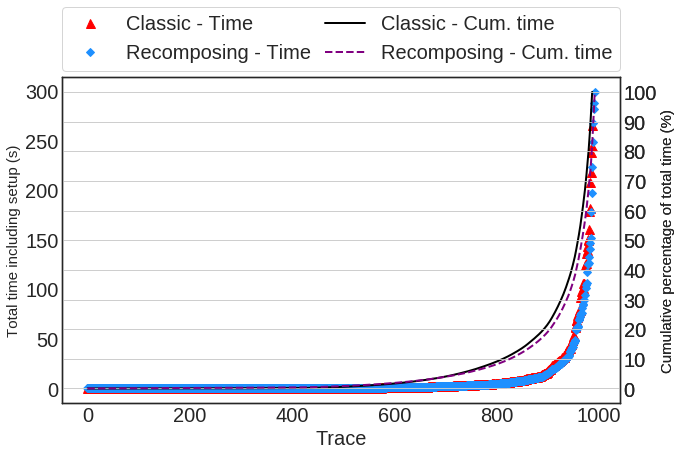

In [563]:
plot_params = {
    'time_color': 'red',
    'time_marker': '^',
    'time_markersize': 9,
    'perc_color': 'black',
    'perc_linestyle': '-',
    'perc_linewidth': 2
}

fig, ax = plot_time_analysis(mono_stats_df_net1_60_60, plot_params)

# make legend
mono_time_patch = mlines.Line2D([], [], color=plot_params['time_color'], linestyle='', 
                           marker=plot_params['time_marker'], markersize=plot_params['time_markersize'], 
                                label='Classic - Time')
mono_perc_patch = mlines.Line2D([], [], color=plot_params['perc_color'], linestyle=plot_params['perc_linestyle'],
                               linewidth=plot_params['perc_linewidth'], label='Classic - Cum. time')

plot_params = {
    'time_color': 'dodgerblue',
    'time_marker': 'D',
    'time_markersize': 5,
    'perc_color': 'purple',
    'perc_linestyle': '--',
    'perc_linewidth': 2
}
plot_time_analysis(reco_sese_stats_df_net1_60_60, plot_params, fig, ax)

# make legend 
reco_time_patch = mlines.Line2D([], [], color=plot_params['time_color'], linestyle='',
                               marker=plot_params['time_marker'], markersize=plot_params['time_markersize'], 
                                label='Recomposing - Time')
reco_perc_patch = mlines.Line2D([], [], color=plot_params['perc_color'], linestyle=plot_params['perc_linestyle'],
                               linewidth=plot_params['perc_linewidth'], label='Recomposing - Cum. time')

# make legend
handles = [
    mono_time_patch,
    reco_time_patch,
    mono_perc_patch,
    reco_perc_patch
]
ax.legend(handles=handles, bbox_to_anchor=(0., 1.02, 1., .102), loc=3, 
         ncol=2, mode='expand', borderaxespad=0., frameon=True)

;

#### Save fig as SVG

fig.tight_layout()
fig.savefig('./motivation-time-chart.svg', bbox_inches='tight', rasterized=True)

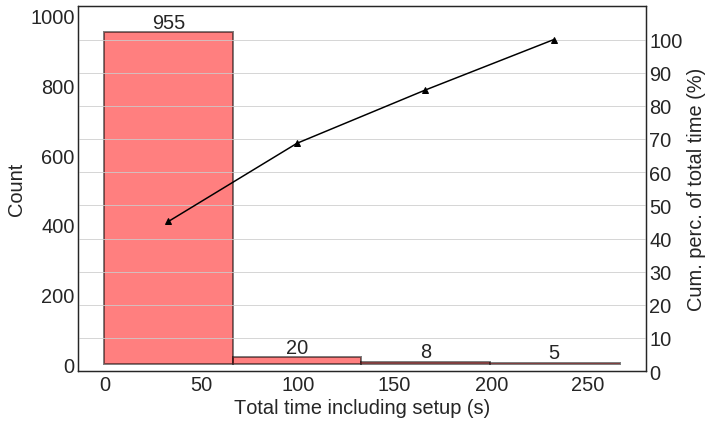

In [748]:
plot_params = {
    'hist_color': 'red',
    'hist_alpha': 0.5,
    'hist_n_bins': 4,
    'hist_edgecolor': 'black',
    'hist_linewidth': 2.,
    'cum_marker': '^',
    'cum_color': 'black',
    'cum_linestyle': '-'
}

fig, ax = plot_time_analysis_2(mono_stats_df_net1_60_60, plot_params)
fig.tight_layout()

#### Save fig as SVG 

In [749]:
fig.savefig('./motivation-time-hist-mono.svg', bbox_inches='tight', rasterized=True)

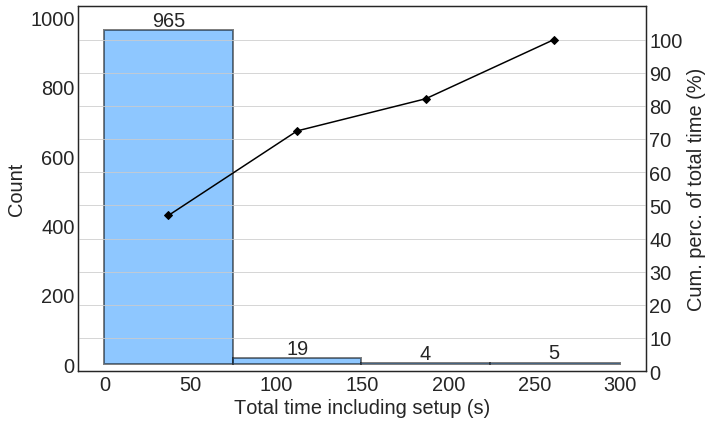

In [750]:
plot_params = {
    'hist_color': 'dodgerblue',
    'hist_alpha': 0.5,
    'hist_n_bins': 4,
    'hist_edgecolor': 'black',
    'hist_linewidth': 2.,
    'cum_marker': 'D',
    'cum_color': 'black',
    'cum_linestyle': '-'
}

fig, ax = plot_time_analysis_2(reco_sese_stats_df_net1_60_60, plot_params)
fig.tight_layout()

#### Save fig as SVG 

In [751]:
fig.savefig('./motivation-time-hist-reco.svg', bbox_inches='tight', rasterized=True)

### Plot trace lengths vs. alignment time

In [ ]:
def plot_algo_analysis(df, plot_params, fig=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    color = plot_params['color']
    marker = plot_params['marker']
    markersize = plot_params['markersize']
    
    alignment_costs = df['merged_alignment_cost'] if 'merged_alignment_cost' in df else df['Cost of the alignment']
    trace_lengths = df['merged_alignment_log_trace_length'] if 'merged_alignment_log_trace_length' in df else df['Length of the orignal trace']
    alignment_times = df['Total Time including setup (us)']
    ax.plot(trace_lengths, alignment_times, marker, color=color, markersize=markersize)
    
    # labels
    ax.set_xlabel('Log trace length')
    ax.set_ylabel('Total time including setup (s)', fontsize=15)
    
    # grid
    ml = MultipleLocator(10.)
    ax.yaxis.set_minor_locator(ml)
    ax.yaxis.grid(which='major', color='k', linestyle='-', linewidth=0.7)
    ax.xaxis.set_minor_locator(ml)
    ax.xaxis.grid(which='minor', color='k', linestyle='-.', linewidth=0.7)
    
    return fig, ax

In [717]:
top_merged_60_60['time_diff'].min()

1.9203030000000005

In [764]:
def plot_algo_analysis_2(df, plot_params, fig=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    hist_n_bins = plot_params['hist_n_bins']
    hist_color = plot_params['hist_color']
    hist_alpha = plot_params['hist_alpha']
    hist_linewidth = plot_params['hist_linewidth']
    hist_edgecolor = plot_params['hist_edgecolor']
    
    cum_marker = plot_params['cum_marker']
    cum_linestyle = plot_params['cum_linestyle']
    cum_color = plot_params['cum_color']
    
    n_traces = df.shape[0]
    
    # compute cumulative data
    time_diff = df['time_diff']
    time_diff_df = df.loc[:,['time_diff']].copy()
    time_diff_df['bin'] = pd.cut(time_diff, hist_n_bins)
    bins = [interval.left for interval in time_diff_df['bin'].dtype.categories] + [time_diff_df['bin'].dtype.categories[-1].right + 1]
    
    # compute cumulative data
    total_time = time_diff.sum()
    n_traces = time_diff.shape[0]
    cum_df = time_diff_df.groupby('bin').agg({'time_diff': ['sum', 'count']})
    cum_df.loc[:,('time_diff', 'sum')] = cum_df.loc[:,('time_diff', 'sum')].cumsum()
    get_mid = lambda interval: (interval.left + interval.right) / 2.
    bin_mid_list = [get_mid(interval) for interval in time_diff_df['bin'].dtype.categories]
    
    ax_twin = ax.twinx()
    n, bins, patches = ax.hist(time_diff, bins=bins, color=hist_color, alpha=hist_alpha,
           linewidth=hist_linewidth, edgecolor=hist_edgecolor)
    cum_time_diff = cum_df.loc[:,('time_diff','sum')]
    ax_twin.plot(bin_mid_list, cum_time_diff, marker=cum_marker, linestyle=cum_linestyle, color=cum_color)
    
    # ylim
    ax.set_ylim([-5, n_traces])
    ax_twin.set_ylim([cum_time_diff.min() - 200, cum_time_diff.max() + 100])

    # labels
    ax.set_xlabel('Time difference (s)')
    ax.set_ylabel('Count')
    ax_twin.set_ylabel('Cum. time difference (s)')
    
    ax_twin.grid()
    
    # histogram labels
    for i in range(hist_n_bins):
        bin_count = n[i]
        bin_mid = (bins[i] + bins[i + 1]) / 2
        text_params = {
            'fontsize': 20,
            'verticalalignment': 'bottom',
            'horizontalalignment': 'center'
        }
        ax.text(bin_mid, bin_count, '{}'.format(bin_count), text_params)
        
    fig.tight_layout()
           
    return fig, ax

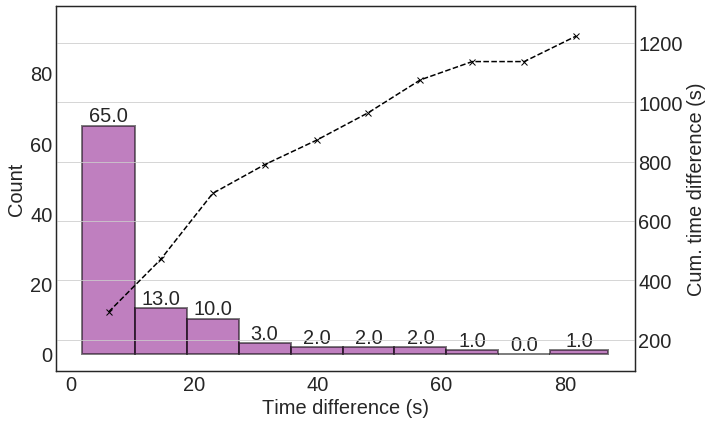

In [765]:
plot_params = {
    'hist_n_bins': 10,
    'hist_color': 'purple',
    'hist_alpha': 0.5,
    'hist_linewidth': 2.,
    'hist_edgecolor': 'black',
    'cum_marker': 'x',
    'cum_linestyle': '--',
    'cum_color': 'black'
}

merged_60_60['time_diff'] = merged_60_60['Total Time including setup (us)_mono'] - merged_60_60['Total Time including setup (us)_reco']
merged_60_60['abs_time_diff'] = abs(merged_60_60['Total Time including setup (us)_mono'] - merged_60_60['Total Time including setup (us)_reco'])
# get the top % in terms of abs time diff
p = 0.90
quantile_time_diff = merged_60_60['time_diff'].quantile(p)
quantile_time_diff_cid = merged_60_60.loc[merged_60_60['time_diff'] > quantile_time_diff, 'SP label']

top_merged_60_60 = merged_60_60[
    (merged_60_60['abs_time_diff'] > quantile_time_diff)
]
fig, ax = plot_algo_analysis_2(top_merged_60_60, plot_params);

In [771]:
merged_60_60.loc[
    (merged_60_60['time_diff'] < 0),
    'Cost of the alignment_mono'
].shape

(554,)

#### Save fig as SVG

In [766]:
fig.savefig('./motivation-time-diff-hist.svg', bbox_inches='tight', rasterized=True)

''

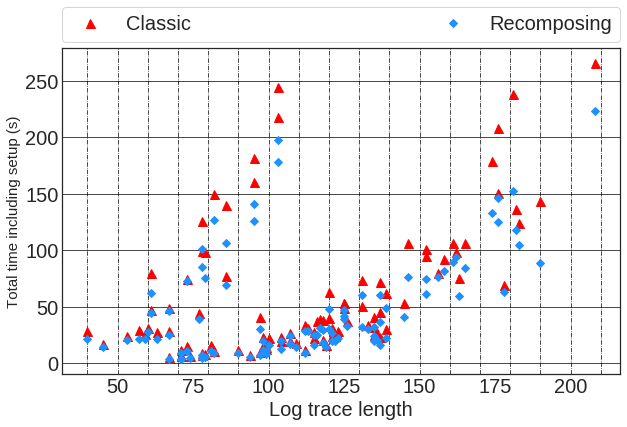

In [704]:
# identify the traces where there are large absolute differences

top_mono_stats_df_net1_60_60 = mono_stats_df_net1_60_60[
    (mono_stats_df_net1_60_60['SP label'].isin(quantile_time_diff_cid))
]

top_reco_sese_stats_df_net1_60_60 = reco_sese_stats_df_net1_60_60[
    (reco_sese_stats_df_net1_60_60['SP label'].isin(quantile_time_diff_cid))
]


# plot alignment
plot_params = {
    'color': 'red',
    'marker': '^',
    'markersize': 9
}

# make legend
mono_patch = mlines.Line2D([], [], color=plot_params['color'], linestyle='',
                          marker=plot_params['marker'], markersize=plot_params['markersize'],
                          label='Classic')

fig, ax = plot_algo_analysis(top_mono_stats_df_net1_60_60, plot_params)

plot_params = {
    'color': 'dodgerblue',
    'marker': 'D',
    'markersize': 5,
}

reco_patch = mlines.Line2D([], [], color=plot_params['color'], linestyle='',
                          marker=plot_params['marker'], markersize=plot_params['markersize'],
                          label='Recomposing')

plot_algo_analysis(top_reco_sese_stats_df_net1_60_60, plot_params, fig, ax)

handles = [
    mono_patch,
    reco_patch
]
ax.legend(handles=handles, bbox_to_anchor=(0., 1.02, 1., .102), loc=3, 
         ncol=2, mode='expand', borderaxespad=0., frameon=True)

;

In [351]:
fig.tight_layout()
fig.savefig('./motivation-algo-chart.svg', bbox_inches='tight', rasterized=True)